In [2]:
import numpy as np 
import pandas as pd 
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

from tsprial.forecasting import ForecastingCascade, ForecastingChain

In [3]:
### UTILITY FUNCTIONS TO SIMULATE TIME SERIES AND STORE FORECASTING METRICS ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y

def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

def gen_ts(timesteps, amp, freq, noise, random_state=0):
    np.random.seed(random_state)
    
    if isinstance(freq, (int,float)):
        seas = gen_sinusoidal(timesteps=timesteps, amp=amp, freq=freq, noise=noise)
    elif np.iterable(freq) and not isinstance(freq, str):
        seas = np.zeros(timesteps)
        for f in freq:
            if isinstance(f, (int,float)):
                seas += \
                    gen_sinusoidal(timesteps=timesteps, amp=amp, freq=f, noise=noise)
            else:
                raise ValueError("freq not understood.")
    else:
        raise ValueError("freq not understood.")
    
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2])
    trend = LinearRegression().fit(X, rw).predict(X)
    
    return seas + trend


def get_metrics(model, X, y, metrics=None):
    
    score = {
        'mse': [model.score(X, y, scoring='mse')],
        'mae': [model.score(X, y, scoring='mae')],
        'mape': [model.score(X, y, scoring='mape')],
        'rmse': [model.score(X, y, scoring='rmse')],
    }
    
    if metrics is not None:
        for metric,s in score.items():
            metrics[metric].extend(s)
    else:
        metrics = score
    
    return metrics

In [4]:
### SIMULATE SYNTHETIC TIME SERIES ### 

n_series, timesteps = 100, 4_000

df = {}
for i in range(n_series):
    df[f'ts_{i}'] = gen_ts(
        timesteps, 
        amp=10, freq=[24,24*7], noise=4,
        random_state=i
    )
df = pd.DataFrame(
    df, index=pd.date_range(
    '2020-01-01', periods=timesteps, freq='H'
    )
)

df.shape

(4000, 100)

<AxesSubplot:>

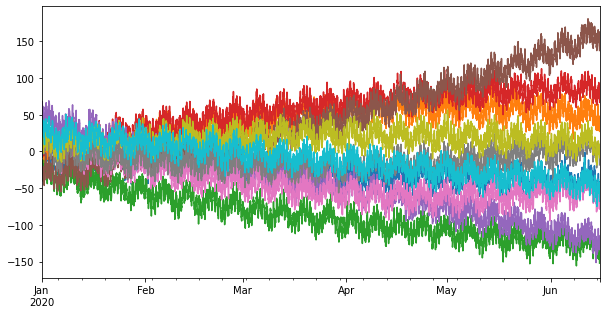

In [5]:
### PLOT SYNTHETIC TIME SERIES ###

df.sample(n=10, axis=1, random_state=33).plot(
    legend=False, figsize=(10,5))

In [6]:
### TRAIN TEST SPLIT ###

y_train, y_test = train_test_split(df, test_size=24*7, shuffle=False)
y_train.shape, y_test.shape

((3832, 100), (168, 100))

In [7]:
### INTIALIZE EMPTY DICT TO STORE RESULTS ###

results = {}

# Recursive Forecasting

In [8]:
### SELECT MEANINGFUL LAGS ###

supports = []

model = ForecastingCascade(
    make_pipeline(
        SelectFromModel(
            Ridge(), 
            threshold='median',
            max_features=72,
        ), 
        Ridge()
    ),
    lags=range(1,24*7+1),
    use_exog=False,
)

for c in tqdm(df.columns):
    
    model.fit(None, y_train[c])
    supports.append(
        model.estimator_['selectfrommodel'].get_support(indices=True)
    )
    
supports = np.asarray(supports)

100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


In [9]:
### FORECASTING WITH ALL LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):
    
    model = ForecastingCascade(
        Ridge(),
        lags=range(1,24*7+1),
        use_exog=False
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['recursive full'] = metrics

print(metrics)

100%|██████████| 100/100 [00:27<00:00,  3.58it/s]

{'mse': 48.05696853461646, 'mae': 5.481909306888324, 'mape': 0.9726704858704206, 'rmse': 6.764007568488088, 'tot time': 9.867992401123047, 'std time': 0.019128306323560055}


In [10]:
### FORECASTING WITH DUMMY LAGS SELECTION ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):
    
    model = ForecastingCascade(
        Ridge(),
        lags=range(24,24*8,24),
        use_exog=False
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['recursive dummy'] = metrics

print(metrics)

100%|██████████| 100/100 [00:01<00:00, 78.09it/s]

{'mse': 67.29899960764841, 'mae': 6.490345961979978, 'mape': 1.2991696821283556, 'rmse': 7.962270165339617, 'tot time': 0.15862774848937988, 'std time': 0.00012661101433459533}


In [11]:
### FORECASTING WITH SELECTED LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):

    model = ForecastingCascade(
        Ridge(),
        lags=supports[i] +1,
        use_exog=False
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['recursive filtered'] = metrics

print(metrics)

100%|██████████| 100/100 [00:19<00:00,  5.14it/s]

{'mse': 48.97977022728355, 'mae': 5.530049636923783, 'mape': 1.0139870577345504, 'rmse': 6.811106627446635, 'tot time': 5.987894773483276, 'std time': 0.013370698869755768}


# Direct Forecasting

In [12]:
### SELECT MEANINGFUL LAGS ###

supports = []

model = ForecastingChain(
    make_pipeline(
        SelectFromModel(
            Ridge(), threshold='median',
        ), 
        Ridge()
    ),
    n_estimators=24*7,
    lags=range(1,24*7+1),
    use_exog=False,
    n_jobs=-1
)

for c in tqdm(df.columns):
    
    model.fit(None, y_train[c])
    supports.append(
        np.argsort(np.asarray([
            est.estimator_['selectfrommodel'].get_support() 
            for est in model.estimators_
        ]).sum(0))[-72:]
    )
    
supports = np.asarray(supports)

100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


In [13]:
### FORECASTING WITH ALL LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):

    model = ForecastingChain(
        Ridge(),
        n_estimators=24*7,
        lags=range(1,24*7+1),
        use_exog=False,
        n_jobs=-1
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['direct full'] = metrics

print(metrics)

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

{'mse': 39.46555415883777, 'mae': 5.0104592132423384, 'mape': 0.7879780084835637, 'rmse': 6.247999158074163, 'tot time': 10.896318197250366, 'std time': 0.014165356989849217}


In [14]:
### FORECASTING WITH DUMMY LAGS SELECTION ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):

    model = ForecastingChain(
        Ridge(),
        n_estimators=7,
        lags=range(24,24*8,24),
        use_exog=False,
        n_jobs=-1
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['direct dummy'] = metrics

print(metrics)

100%|██████████| 100/100 [00:02<00:00, 41.02it/s]

{'mse': 63.91225292359602, 'mae': 6.340832101317055, 'mape': 1.2505373067543006, 'rmse': 7.7900026565666725, 'tot time': 0.13086938858032227, 'std time': 0.00013290324497264847}


In [15]:
### FORECASTING WITH SELECTED LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):
    
    model = ForecastingChain(
        Ridge(),
        n_estimators=round(24*7 / (supports[i].min() +1)), 
        lags=supports[i] +1, 
        use_exog=False,
        n_jobs=-1
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['direct filtered'] = metrics

print(metrics)

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

{'mse': 41.687250738547135, 'mae': 5.153754897129753, 'mape': 0.8724183044550441, 'rmse': 6.414979337303102, 'tot time': 4.806384801864624, 'std time': 0.018682170116502975}


In [16]:
### SHOW RESULTS IN TABULAR FORMAT ###

results = pd.DataFrame(results).T
results

,mse,mae,mape,rmse,tot time,std time
recursive full,48.056969,5.481909,0.972670,6.764008,9.867992,0.019128
recursive dummy,67.299000,6.490346,1.299170,7.962270,0.158628,0.000127
recursive filtered,48.979770,5.530050,1.013987,6.811107,5.987895,0.013371
direct full,39.465554,5.010459,0.787978,6.247999,10.896318,0.014165
direct dummy,63.912253,6.340832,1.250537,7.790003,0.130869,0.000133
direct filtered,41.687251,5.153755,0.872418,6.414979,4.806385,0.018682


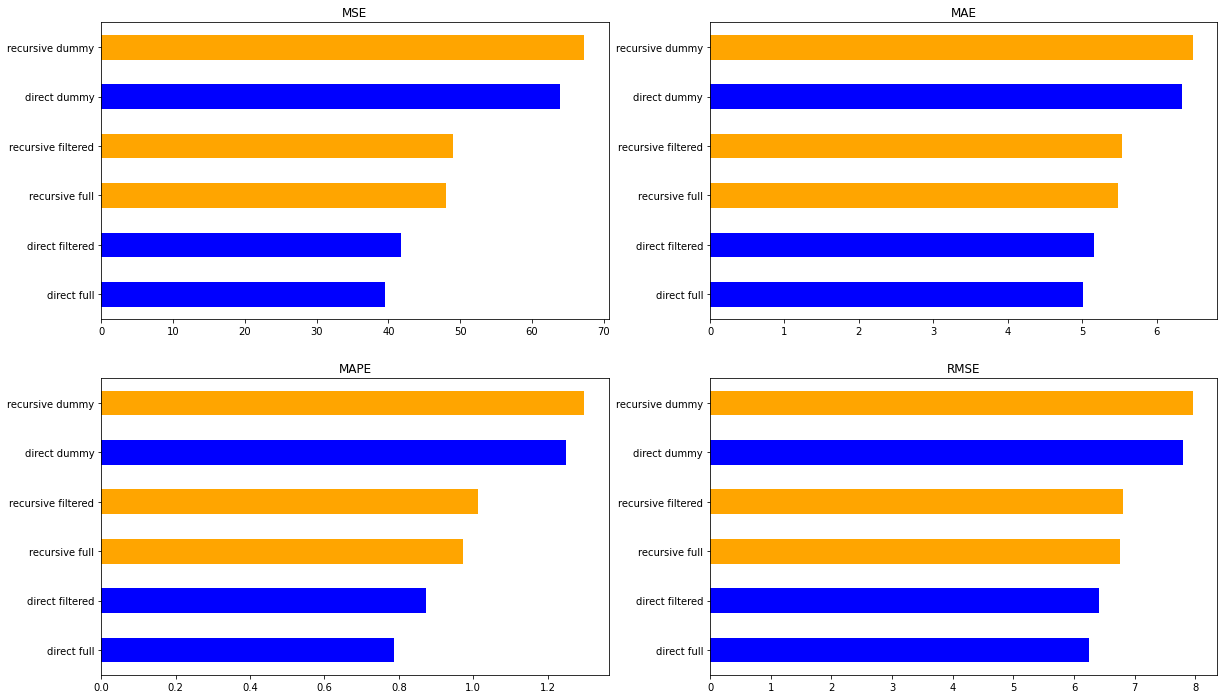

In [17]:
### PLOT FORECASTING ERRORS ###

plt.figure(figsize=(20,12))

plt.subplot(221)
res = results['mse'].sort_values()
res.plot(
    kind='barh', title='MSE',
    color=['orange' if 'recursive' in r else 'blue' for r in res.index]
)

plt.subplot(222)
res = results['mae'].sort_values()
res.plot(
    kind='barh', title='MAE',
    color=['orange' if 'recursive' in r else 'blue' for r in res.index],
)

plt.subplot(223)
res = results['mape'].sort_values()
res.plot(
    kind='barh', title='MAPE',
    color=['orange' if 'recursive' in r else 'blue' for r in res.index],
)

plt.subplot(224)
res = results['rmse'].sort_values()
res.plot(
    kind='barh', title='RMSE',
    color=['orange' if 'recursive' in r else 'blue' for r in res.index],
)

plt.show()

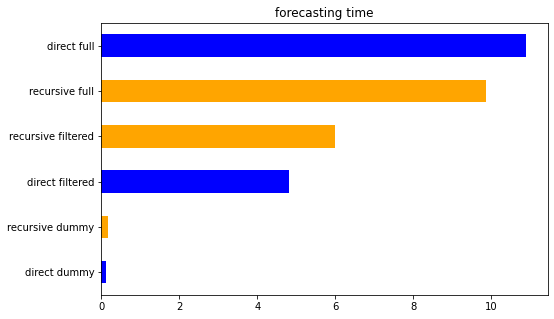

In [18]:
### PLOT INFERENCE TIME ###

plt.figure(figsize=(8,5))

res = results['tot time'].sort_values()
res.plot(
    kind='barh', title='forecasting time',
    color=['orange' if 'recursive' in r else 'blue' for r in res.index]
)

plt.show()